# Treinando o Modelo

In [171]:
import pandas as pd
df_train = pd.read_csv('entrega-1/df_treino_fairness.csv')
df_test = pd.read_csv('entrega-1/df_teste_fairness.csv')


In [172]:
print(df_train['Resultado'].value_counts())
print(df_test['Resultado'].value_counts())
print(df_train.shape)
print(df_test.shape)

0    5626
1     158
Name: Resultado, dtype: int64
0    1409
1      32
Name: Resultado, dtype: int64
(5784, 21)
(1441, 21)


In [173]:
df_test.columns

Index(['Quantidade ovos encontrados', 'Escolaridade', 'Sexo', 'Resultado',
       'Exame_Nao_Realizado', 'Exame_Negativo', 'Exame_Positivo',
       'Tratamento_Nao', 'Tratamento_Sim_Oxaminiquine',
       'Tratamento_Sim_Praziquantel', 'Forma_Aguda', 'Forma_Hepato_Esplenica',
       'Forma_Hepato_Intestinal', 'Forma_Intestinal', 'Forma_Outra', 'Idade',
       'Regiao_Centro-Oeste', 'Regiao_Nordeste', 'Regiao_Norte',
       'Regiao_Sudeste', 'Regiao_Sul'],
      dtype='object')

In [174]:
# Dropping all rows where sexo is I
df_test = df_test[df_test['Sexo'] != 'I']
df_train = df_train[df_train['Sexo'] != 'I']

df_test.info()
# Redefining sexo to integer type
df_test['Sexo'] = df_test['Sexo'].astype('int')
df_train['Sexo'] = df_train['Sexo'].astype('int')
df_train['Sexo'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 1440
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Quantidade ovos encontrados  1441 non-null   int64
 1   Escolaridade                 1441 non-null   int64
 2   Sexo                         1441 non-null   int64
 3   Resultado                    1441 non-null   int64
 4   Exame_Nao_Realizado          1441 non-null   int64
 5   Exame_Negativo               1441 non-null   int64
 6   Exame_Positivo               1441 non-null   int64
 7   Tratamento_Nao               1441 non-null   int64
 8   Tratamento_Sim_Oxaminiquine  1441 non-null   int64
 9   Tratamento_Sim_Praziquantel  1441 non-null   int64
 10  Forma_Aguda                  1441 non-null   int64
 11  Forma_Hepato_Esplenica       1441 non-null   int64
 12  Forma_Hepato_Intestinal      1441 non-null   int64
 13  Forma_Intestinal             1441 non-null   int

array([0, 1])

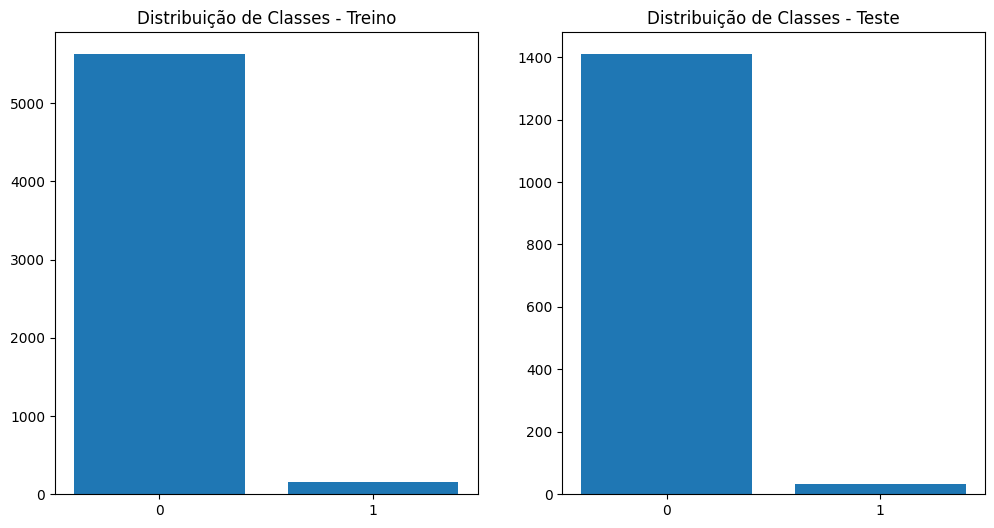

In [175]:
# Plotando a divisão de classes para conjunto de treino e teste lado a lado
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)

classes = [0,1]
counts = [df_train['Resultado'].value_counts().get(c, 0) for c in classes]
plt.bar(x=classes, height=counts, tick_label=classes)
plt.title('Distribuição de Classes - Treino')


ax2 = plt.subplot(122)
counts = [df_test['Resultado'].value_counts().get(c, 0) for c in classes]
plt.bar(x=classes, height=counts, tick_label=classes)
plt.title('Distribuição de Classes - Teste')

plt.savefig('./source/images/distribuicao_classes_fairness.png')

In [176]:
y_test = df_test['Resultado'].to_numpy()
X_test = df_test.drop(['Resultado'], axis=1).to_numpy()

In [177]:
y_train = df_train['Resultado'].to_numpy()
X_train = df_train.drop(['Resultado'], axis=1).to_numpy()

In [178]:
y_train_save = y_train
X_train_save = X_train

## 1) Balanceando as classes

Primeiramente, precisamos garantir representatividade de ao menos 1,5x da classe majoritária sobre a minoritária. Como temos consideravelmente mais instâncias de pessoas que não faleceram, vamos buscar utilizar diferentes técnicas tanto para selecionar instâncias da classe majoritária quanto para aumentar as instâncias da classe majoritária

Para isso, iremos utilizar a biblioteca imblearn

In [179]:
# !pip install imblearn

Primeiramente, aumentar a instância da classe minoritaria até atingir 20% da majoritária

In [180]:
from imblearn.over_sampling import SMOTE
import numpy as np

oversample = SMOTE(sampling_strategy=0.2, random_state=42)
print("Quantidade da classe minoritária antes da aumentação: ", np.unique(y_train, return_counts=True))

X_train, y_train = oversample.fit_resample(X_train, y_train)
print("Quantidade da classe minoritária após aumentação: ", np.unique(y_train, return_counts=True))

Quantidade da classe minoritária antes da aumentação:  (array([0, 1]), array([5626,  158]))
Quantidade da classe minoritária após aumentação:  (array([0, 1]), array([5626, 1125]))


Agora, vamos utilizar undersampling para reduzir a classe majoritária. 

In [181]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(sampling_strategy={0:1687,1:1125})
X_train, y_train = nm.fit_resample(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

(2812, 20)
(2812,)


In [182]:
import numpy as np
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([1687, 1125]))


Analisando a variável central para o balanceamento (Escolaridade)

In [183]:
Sexo_idx = df_train.columns.get_loc('Sexo')
Sexo_labels = {0: "Masculino", 1: "Feminino"}

# Verificando a distribuição de Sexo    
df_train['Sexo'].value_counts()

# Analisando a quantidade de óbitos para cada Sexo
Sexo_counts = df_train.groupby('Sexo')['Resultado'].value_counts().unstack(fill_value=0)
df_Sexo = pd.DataFrame(Sexo_counts)

# Renomear os índices (linhas) e as colunas
df_Sexo = df_Sexo.rename(index={0: "Masculino", 1: "Feminino"},
                                            columns={0: "Não óbito", 1: "Óbito"})

# Calculate the mortality rate as percentage (numeric)
df_Sexo["Taxa de Mortalidade"] = (df_Sexo["Óbito"] / (df_Sexo["Óbito"] + df_Sexo["Não óbito"])) * 100

# Format the values as strings with two decimals and a '%' symbol
df_Sexo["Taxa de Mortalidade"] = df_Sexo["Taxa de Mortalidade"].apply(lambda x: f"{x:.2f}%")

# Exibir o resultado
df_Sexo.head()

Resultado,Não óbito,Óbito,Taxa de Mortalidade
Sexo,,,
Masculino,3408,77,2.21%
Feminino,2218,81,3.52%


## 2) Treinamento do modelo

A análise anterior foi usada apenas para demonstrar como devem ser balanceados os modelos. O balanceamento será realizado dentro dos folds de treinamento para cada iteração do k-fold, a fim de que a valicação reflita melhor os padrões que serão vistos nos conjuntos de teste

In [184]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.metrics import classification_report

X_train = X_train_save
y_train = y_train_save

print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([5626,  158]))


In [185]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

param_grids = {
    'kNN': {
        'n_neighbors': [1, 5, 10],
        'p': [1, 2],
        'weights': ['uniform', 'distance']
    },
    'Logistic Regression': {
        'class_weight': ['balanced', {0: 1, 1: 1}]
    },
    'Random Forest': {
        'n_estimators': [10, 100, 200],
        'max_depth': [10, 50],
        'min_samples_split': [2, 10, 30]
    }
}


In [186]:
print(X_train.shape)
print(type(X_train))

(5784, 20)
<class 'numpy.ndarray'>


Agora que já temos os parâmetros iniciais, instanciando os modelos:

In [187]:
# Modelos base
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)

models = [('kNN', knn), ('Logistic Regression', lr), ('Random Forest', rf)]

In [188]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, f1_score, precision_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

save_best_models = {'kNN':[], 'Logistic Regression':[], 'Random Forest':[]}
predictions_per_model = {'kNN':[], 'Logistic Regression':[], 'Random Forest':[]}

all_reports = {}
for name, base_model in models:

    print(f"MODELO: {name}")
    all_reports[name] = []
    predictions_per_model[name] = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        print(f'Fold {fold+1}')
        X_train_fold, X_val = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val = y_train[train_idx], y_train[val_idx]

        # Transformando classe minoritária em 20% da classe majoritária
        oversample = SMOTE(sampling_strategy=0.2, random_state=42)
        X_train_fold, y_train_fold = oversample.fit_resample(X_train_fold, y_train_fold)

        # Transformando classe majoritária em 1.5x da minoritária
        nm = NearMiss(sampling_strategy=0.6)
        X_train_fold, y_train_fold = nm.fit_resample(X_train_fold, y_train_fold)

        # Clonando o modelo
        model = clone(base_model)

        # Analisando a porcentagem de mortes para cada Sexo
        unique_Sexos = np.unique(X_train_fold[:, Sexo_idx])
        for sexo_uni in unique_Sexos:

            mask = X_train_fold[:, Sexo_idx] == sexo_uni # True apenas para aquele sexo específico
            death_count = np.sum(y_train_fold[mask] == 1) # Total de mortes para aquele sexo específico
            death_pct = death_count / np.sum(mask) # Porcentagem de mortes para aquele sexo específico

            label = Sexo_labels.get(sexo_uni, sexo_uni)
            print(f"Fold {fold+1} - Sexo '{label}' antes de balancear: {(death_pct*100):.2f}% de mortes ({death_count} mortes em {np.sum(mask)} pessoas)")

        # Balanceando taxas de morte entre Sexo=0 e 1 (versão invertida)
        sexoMasculino_mask = X_train_fold[:, Sexo_idx] == 0
        sexoFeminino_mask = X_train_fold[:, Sexo_idx] == 1

        # Filtrando os grupos
        X_sexoMasculino = X_train_fold[sexoMasculino_mask]
        y_sexoMasculino = y_train_fold[sexoMasculino_mask]

        X_sexoFeminino = X_train_fold[sexoFeminino_mask]
        y_sexoFeminino = y_train_fold[sexoFeminino_mask]

        # Contando mortes em cada grupo
        deathsMasculino = np.sum(y_sexoMasculino == 1)
        deathsFeminino = np.sum(y_sexoFeminino == 1)
        
        # Contando o total de cada grupo
        totalMasculino = len(y_sexoMasculino)
        totalFeminino = len(y_sexoFeminino)

        # Calculando a taxa de morte para cada grupo
        rateMasculino = deathsMasculino/ totalMasculino
        rateFeminino = deathsFeminino/ totalFeminino

        # Calculando quantas mulheres devem ser aumentadas para igualar com o número de homens
        difference = totalMasculino - totalFeminino
        print("Diferença entre homens e mulheres: ", difference)

        over_pct = totalMasculino / totalFeminino
        # Calculando a sampling strategy para o número de mulheres se igualar ao de homens
        sampling_strategy = {1: int(deathsFeminino * (over_pct)) , 0:int((totalFeminino - deathsFeminino) * over_pct)}  # Aumentando mulheres para igualar com homens

        # Aplicando o SMOTE para balancer homens e mulheres com 50/50
        oversampleFeminino = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_sexoFeminino_res, y_sexoFeminino_res = oversampleFeminino.fit_resample(X_sexoFeminino, y_sexoFeminino)
        print("Quantidade de mulheres após o SMOTE: ", len(y_sexoFeminino_res))

        # Concatenando os novos exemplos femininos com os antigos masculinos para balancear
        X_train_fold = np.concatenate((X_sexoMasculino, X_sexoFeminino_res), axis=0)
        y_train_fold = np.concatenate((y_sexoMasculino, y_sexoFeminino_res), axis=0)

        # Analisando a porcentagem de mortes para cada Sexo
        unique_Sexos = np.unique(X_train_fold[:, Sexo_idx])

        for sexo_uni in unique_Sexos:
            # Get a boolean mask for rows where Sexo equals sexo_uni
            mask = X_train_fold[:, Sexo_idx] == sexo_uni
            # Count deaths (assuming y_train_fold==1 means death)
            death_count = np.sum(y_train_fold[mask] == 1)
            death_pct = death_count / np.sum(mask)
            # Map the numeric Sexo value to a descriptive label
            label = Sexo_labels.get(sexo_uni, sexo_uni)
            print(f"Fold {fold+1} - Sexo '{label}' atualizado: {(death_pct*100):.2f}% de mortes ({death_count} mortes em {np.sum(mask)} pessoas)")

        # Definindo o GridSearch
        grid = GridSearchCV(
            model,
            param_grid=param_grids[name],
            scoring={'recall': 'recall', 'precision': 'precision'},
            refit='recall',  # Mais importante para prever o nosso modelo
            cv=5,
            n_jobs=1)

        # Ajustando o modelo com os dados balanceados
        grid.fit(X_train_fold, y_train_fold)

        # Usando o melhor modelo
        best_model = grid.best_estimator_

        # Avaliando o modelo
        y_pred = best_model.predict(X_val)

        # Calculando as métricas
        accuracy = accuracy_score(y_val, y_pred)
        balanced_acc = balanced_accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        precision = precision_score(y_val, y_pred, zero_division=0)

        # Salvando como lista [acc, balanced_acc, recall, f1]
        metrics = {'model_iteration': f'{name}_{fold}','precision': precision,'accuracy': accuracy, 'balanced_accuracy': balanced_acc, 'recall': recall, 'f1_score': f1}
        all_reports[name].append(metrics)

        # Mostrando a distribuição do y treino, para ver se o 60% foi respeitado
        print("Distribuição e treino: ", np.unique(y_train_fold, return_counts=True))
        print("--------------------------------------------------------------------------------------------")


        save_best_models[name].append(best_model)
        predictions_per_model[name].append({'predicted': y_pred, 'actual': y_val})
    

MODELO: kNN
Fold 1
Fold 1 - Sexo 'Masculino' antes de balancear: 34.51% de mortes (538 mortes em 1559 pessoas)
Fold 1 - Sexo 'Feminino' antes de balancear: 43.04% de mortes (362 mortes em 841 pessoas)
Diferença entre homens e mulheres:  718
Quantidade de mulheres após o SMOTE:  1558
Fold 1 - Sexo 'Masculino' atualizado: 34.51% de mortes (538 mortes em 1559 pessoas)
Fold 1 - Sexo 'Feminino' atualizado: 43.07% de mortes (671 mortes em 1558 pessoas)
Distribuição e treino:  (array([0, 1]), array([1908, 1209]))
--------------------------------------------------------------------------------------------
Fold 2
Fold 2 - Sexo 'Masculino' antes de balancear: 38.16% de mortes (632 mortes em 1656 pessoas)
Fold 2 - Sexo 'Feminino' antes de balancear: 36.02% de mortes (268 mortes em 744 pessoas)
Diferença entre homens e mulheres:  912
Quantidade de mulheres após o SMOTE:  1655
Fold 2 - Sexo 'Masculino' atualizado: 38.16% de mortes (632 mortes em 1656 pessoas)
Fold 2 - Sexo 'Feminino' atualizado: 36

Para cada modelo treinado, avaliaremos os folds, escolhendo um melhor. O critério principal será o f1 score, e como desempate o recall, e posteriormente a acurácia balanceada.

In [189]:
metrics_knn = pd.DataFrame(all_reports['kNN'], columns=['model_iteration','precision','accuracy', 'balanced_accuracy', 'recall', 'f1_score'])
metrics_logreg = pd.DataFrame(all_reports['Logistic Regression'], columns=['model_iteration', 'precision', 'accuracy', 'balanced_accuracy', 'recall', 'f1_score'])
metrics_rf = pd.DataFrame(all_reports['Random Forest'], columns=['model_iteration', 'precision', 'accuracy', 'balanced_accuracy', 'recall', 'f1_score'])

metrics = pd.concat([metrics_knn, metrics_logreg, metrics_rf], axis=0)
metrics

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,kNN_0,0.164179,0.934313,0.652553,0.354839,0.224490
1,kNN_1,0.175676,0.930856,0.676014,0.406250,0.245283
2,kNN_2,0.205882,0.920484,0.792125,0.656250,0.313433
3,kNN_3,0.205479,0.935177,0.708597,0.468750,0.285714
4,kNN_4,0.240964,0.935986,0.794581,0.645161,0.350877
0,Logistic Regression_0,0.250000,0.949006,0.707156,0.451613,0.321839
1,Logistic Regression_1,0.206897,0.942956,0.667056,0.375000,0.266667
2,Logistic Regression_2,0.291667,0.946413,0.805458,0.656250,0.403846
3,Logistic Regression_3,0.327869,0.954192,0.794278,0.625000,0.430108
4,Logistic Regression_4,0.300000,0.948962,0.816932,0.677419,0.415842


Escolhendo o melhor fold para cada algoritmo, considerando o recall como métrica principal

In [190]:
# O que obteve o melhor resultado foi o Knn_4
metrics_knn

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,kNN_0,0.164179,0.934313,0.652553,0.354839,0.224490
1,kNN_1,0.175676,0.930856,0.676014,0.406250,0.245283
2,kNN_2,0.205882,0.920484,0.792125,0.656250,0.313433
3,kNN_3,0.205479,0.935177,0.708597,0.468750,0.285714
4,kNN_4,0.240964,0.935986,0.794581,0.645161,0.350877


In [191]:
# O que obteve o melhor resultado foi o log_4
metrics_logreg

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,Logistic Regression_0,0.250000,0.949006,0.707156,0.451613,0.321839
1,Logistic Regression_1,0.206897,0.942956,0.667056,0.375000,0.266667
2,Logistic Regression_2,0.291667,0.946413,0.805458,0.656250,0.403846
3,Logistic Regression_3,0.327869,0.954192,0.794278,0.625000,0.430108
4,Logistic Regression_4,0.300000,0.948962,0.816932,0.677419,0.415842


In [192]:
# O que obteve o melhor resultado foi o rf_3
metrics_rf

,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
0,Random Forest_0,0.392857,0.968021,0.669871,0.354839,0.372881
1,Random Forest_1,0.178571,0.956785,0.567903,0.156250,0.166667
2,Random Forest_2,0.360000,0.960242,0.767028,0.562500,0.439024
3,Random Forest_3,0.437500,0.968885,0.710750,0.437500,0.437500
4,Random Forest_4,0.333333,0.962803,0.682882,0.387097,0.358209


Agora, selecionaremos o melhor de cada um dos algoritmos, para efeito de comparação:

In [193]:
best_metrics = metrics.loc[
    (metrics['model_iteration'] == 'kNN_4') | 
    (metrics['model_iteration'] == 'Logistic Regression_4') |
    (metrics['model_iteration'] == 'Random Forest_3')
]
best_metrics


,model_iteration,precision,accuracy,balanced_accuracy,recall,f1_score
4,kNN_4,0.240964,0.935986,0.794581,0.645161,0.350877
4,Logistic Regression_4,0.300000,0.948962,0.816932,0.677419,0.415842
3,Random Forest_3,0.437500,0.968885,0.710750,0.437500,0.437500


Apesar de ter o melhor f1_score, em virtude do recall baixo em comparação os outros modelos, o random forest foi desconsiderado, já que o recall é uma métrica mais importante para o objetivo da predição.
Apesar da regressão logística ser consideravelmente superior na precisão, teve um recall um pouco mais baixo. Portanto, como no nosso caso é importante que, caso uma pessoa vá a óbito, o nosso modelo acerte, mesmo que ainda preveja errado algumas outras, consideraremos o recall como métrica mais importante nesse caso, e o Knn se mostrou mais robusto nesse sentido.

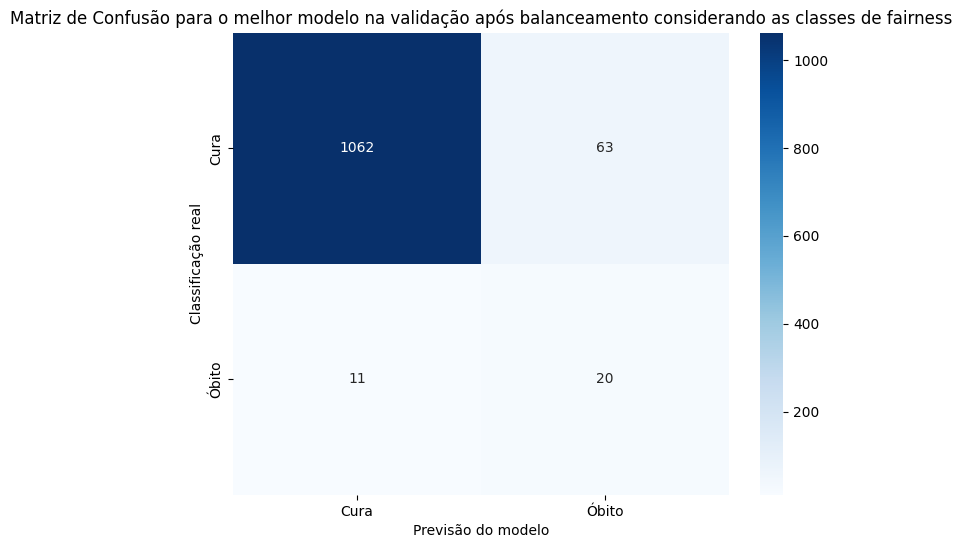

In [194]:
# Mostrando a matriz de confusão para o melhor modelo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = predictions_per_model['kNN'][4]['actual']
y_pred = predictions_per_model['kNN'][4]['predicted']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cura', 'Óbito'], yticklabels=['Cura', 'Óbito'])
plt.xlabel('Previsão do modelo')
plt.ylabel('Classificação real')
plt.title('Matriz de Confusão para o melhor modelo na validação após balanceamento considerando as classes de fairness')
plt.savefig('./source/images/matriz_confusao_validacao_fairness.png')


## Testando o melhor modelo

In [195]:
melhor_modelo = save_best_models['kNN'][4]
y_pred = melhor_modelo.predict(X_test)


Calculando as métricas para o melhor modelo no conjunto de testes:

In [196]:
results = pd.DataFrame({'precision': [precision_score(y_test, y_pred)],
              'recall': [recall_score(y_test, y_pred)],
              'f1_score': [f1_score(y_test, y_pred)]})

results



,precision,recall,f1_score
0,0.211538,0.6875,0.323529


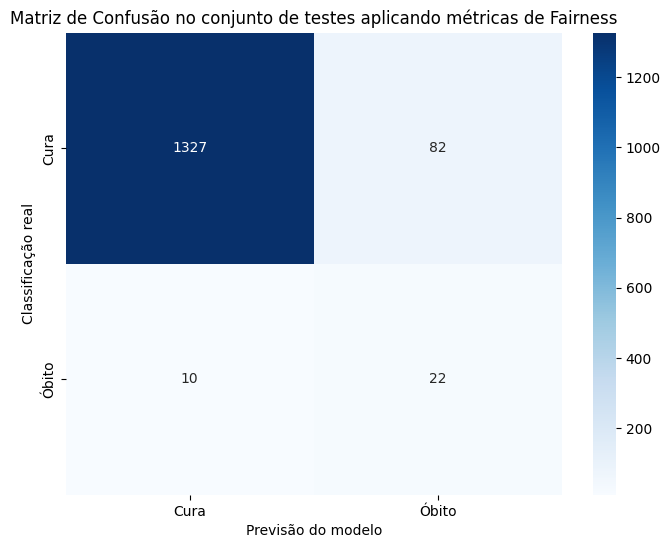

In [197]:

# Mostrando a matriz de confusão para o melhor modelo
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cura', 'Óbito'], yticklabels=['Cura', 'Óbito'])
plt.xlabel('Previsão do modelo')
plt.ylabel('Classificação real')
plt.title('Matriz de Confusão no conjunto de testes aplicando métricas de Fairness')
plt.savefig('./source/images/matriz_confusao_teste_fairness.png')

### Salvando o melhor modelo

In [198]:
import pickle

melhor_modelo = save_best_models['kNN'][4]
with open('./source/models/best_model_fairness_sexo.pkl', 'wb') as f:
    pickle.dump(melhor_modelo, f)
